In [32]:
from path import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from util_api import load_dispNet, infer_model, read_txt

### 推理深度保存到目录中

In [15]:
def infer_path(files, model):
    print("==> infering")
    depths = []
    for file in tqdm(files):
        depths.append(infer_model(model, file))
    return depths

def save_scene_depth(depths, filenames, save_path):
    print("==> saving")
    for i in range(len(depths)):
        filename = filenames[i]
        # print(filename)
        # print(save_path)
        np.save(save_path/filename+'.npy', depths[i])

In [10]:
scene_root_path = Path("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth")
scene_txt_path = "/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/val.txt"

model_path = "/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scenes_all_lossDepth-Anything/24-04-22-20:45/dispnet_4_checkpoint.pth.tar"
save_root_path = Path("/home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424")

model = load_dispNet(model_path)

scene_names = read_txt(scene_txt_path)
scenes = [scene_root_path/scene for scene in scene_names]

for s in scenes: print(s)

/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a
/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t2_a
/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t3_a
/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_sigmoid_t3_a
/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t2_a
/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t3_a
/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t4_a


In [17]:

maxs, mins = [], []

for i in range(len(scenes)):
    scene = scenes[i]
    print("=> processing", scene)
    img_files = sorted(scene.listdir("*.jpg"))
    depths = infer_path(img_files, model)

    scene_save_path = save_root_path/scene_names[i][6:]
    scene_save_path.makedirs_p()
    
    save_scene_depth(depths, [ttt.split('/')[-1][:-4] for ttt in img_files], scene_save_path)
    
    maxs.append(max([t.max() for t in depths]))
    mins.append(min([t.min() for t in depths]))


    

=> processing /home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a
==> infering


100%|██████████| 276/276 [00:04<00:00, 59.05it/s]


==> saving
=> processing /home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t2_a
==> infering


100%|██████████| 370/370 [00:06<00:00, 59.13it/s]


==> saving
=> processing /home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t3_a
==> infering


100%|██████████| 730/730 [00:12<00:00, 58.82it/s]


==> saving
=> processing /home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_sigmoid_t3_a
==> infering


100%|██████████| 613/613 [00:10<00:00, 58.02it/s]


==> saving
=> processing /home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t2_a
==> infering


100%|██████████| 194/194 [00:03<00:00, 57.51it/s]


==> saving
=> processing /home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t3_a
==> infering


100%|██████████| 250/250 [00:04<00:00, 57.77it/s]


==> saving
=> processing /home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_trans_t4_a
==> infering


100%|██████████| 382/382 [00:06<00:00, 57.53it/s]


==> saving


scene_name 			 max 			 min		
-----------------------------------------------------
scene_cecum_t1_a 		 0.5250387 		 0.09980039
scene_cecum_t2_a 		 0.5089335 		 0.09980039
scene_cecum_t3_a 		 0.48005617 		 0.09980039
scene_sigmoid_t3_a 		 0.466748 		 0.09980039
scene_trans_t2_a 		 0.6873442 		 0.09980039
scene_trans_t3_a 		 0.5640062 		 0.09980039
scene_trans_t4_a 		 0.4952931 		 0.09980039
[0.5250387, 0.5089335, 0.48005617, 0.466748, 0.6873442, 0.5640062, 0.4952931]


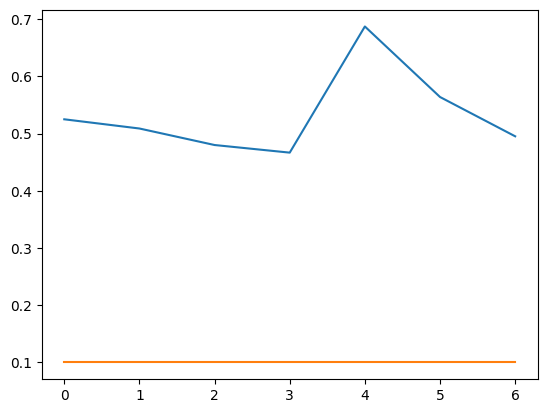

In [34]:
"展示最大最小值的情况"

print("scene_name \t\t\t max \t\t\t min\t\t")
print("-----------------------------------------------------")
for i in range(len(scene_names)):
    scene_name = scene_names[i]
    
    print(scene_name,"\t\t", maxs[i], "\t\t", mins[i])

plt.plot(maxs)
plt.plot(mins)



### 将npy的深度图转换成最大是15000的png图

In [40]:
def transfer_to_png(depths, max_value):
    depths = [depth/max_value for depth in depths]
    depths = [depth*15000 for depth in depths]
    depths = [depth.astype(np.uint16) for depth in depths]
    return depths

def save_to_png(png_depths, save_path):
    for i in range(len(png_depths)):
        png_depth = png_depths[i]
        save_name = f"frame-{i:06d}.depth.png"
        cv2.imwrite(save_path/save_name, png_depth)

In [42]:
npy_root_path = Path("/home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output")
scenes = sorted(npy_root_path.listdir())

maxs = [0.5250387, 0.5089335, 0.48005617, 0.466748, 0.6873442, 0.5640062, 0.4952931]

png_save_path = Path("/home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424")

for i in range(len(scenes)):
    scene = scenes[i]
    print("=> processing ",scene)
    scene_name = scene.split('/')[-1]
    scene_save_path = png_save_path/scene_name/"depth"
    scene_save_path.makedirs_p()
    
    depths = [np.load(t) for t in sorted(scene.listdir("*.npy"))]
    png_depths = transfer_to_png(depths, maxs[i])
    save_to_png(png_depths, scene_save_path)
    

=> processing  /home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output/cecum_t1_a
=> processing  /home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output/cecum_t2_a
=> processing  /home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output/cecum_t3_a
=> processing  /home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output/sigmoid_t3_a
=> processing  /home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output/trans_t2_a
=> processing  /home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output/trans_t3_a
=> processing  /home/jiahan/jiahan/datasets/C3VD_surfelMeshing/240424/SC_depth_output/trans_t4_a
